# Chapter 4 - Basics of Deep Learning

In [3]:
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import tqdm

from random import choice
from numpy import array, dot, random
import sklearn.datasets
import sklearn.linear_model
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm_notebook as tqdm
import copy
import itertools
import pandas as pd

np.random.seed(1)
%matplotlib inline

## MLP on Various Datasets
The example explores a two-layer neural network implemented in python and numpy. Uncomment the dataset to be explored:

- Moons Dataset
- Circles Dataset
- XOR
- AND

Modified example from: https://github.com/dennybritz/nn-from-scratch

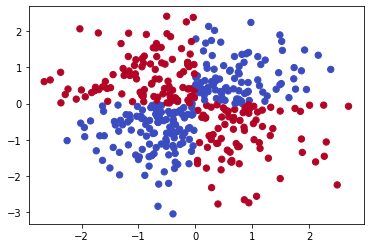

In [18]:
## Generate a dataset and plot it
"""
## Moons Dataset ##
X, y = sklearn.datasets.make_moons(200, noise=0.20)
"""

"""
## Circles dataset ##
X, y = sklearn.datasets.make_circles(noise=0.2, factor=0.5, random_state=1)
"""


## XOR with noise ##
xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)
X = rng.randn(400, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)

"""
## AND with noise ##
xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)
X = rng.randn(400, 2)
y = np.logical_and(X[:, 0] > 0, X[:, 1] > 0).astype(int)
"""

# Plot the dataset
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.coolwarm)

In [19]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

In [20]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function, don't worry. It just generates
# the contour plot below
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [24]:
def calculate_probs(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = x.dot(X1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return probs

In [25]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    probs = calculate_probs(model, X)
    # Calculating the loss
    correct_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(correct_logprobs)
    # Add regularization term to loss (optional)
    data_loss += reg_lambda / 2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [26]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    probs = calculate_probs(model)
    return np.argmax(probs, axis=1)